# **Vision Transformer (ViT)**

## Introdução

Este exemplo implementa o modelo Vision Transformer (ViT) de Alexey Dosovitskiy et al. para classificação de imagens. O modelo ViT aplica a arquitetura Transformer com autoatenção às sequências de patches de imagem, sem usar camadas de convolução.

Link do tutorial no Keras: https://keras.io/examples/vision/image_classification_with_vision_transformer/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

In [ ]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 15.0 MB/s 


In [ ]:
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#Adicionado
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import pathlib
import cv2 as cv


## Preparando os dados

In [ ]:
num_classes = 2
input_shape = (224, 224, 3)
image_size = 224
IMG_SIZE = (224,224)

In [ ]:
train_dir = '/content/drive/MyDrive/Disciplina 10 - Visão Computacional 2/breakHis_dataset/SiDi_BreakHis400x_Balanceado/train_set'
val_dir = '/content/drive/MyDrive/Disciplina 10 - Visão Computacional 2/breakHis_dataset/SiDi_BreakHis400x_Balanceado/validation_set'
test_dir = '/content/drive/MyDrive/Disciplina 10 - Visão Computacional 2/breakHis_dataset/brecahad_TEST/brecahad_test_set'

train_datagen = ImageDataGenerator(rescale=1.0/255.0)
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train=train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=32,
                                              class_mode='categorical')

val=validation_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=32,
                                                   class_mode='categorical')
test=test_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=32,
                                                   class_mode='categorical')

Found 2074 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Found 159 images belonging to 2 classes.


In [ ]:
data_dir_train = pathlib.Path('/content/drive/MyDrive/Disciplina 10 - Visão Computacional 2/breakHis_dataset/BreakHis400x_Balanceado/train_set')

# creating a list of class_names from the subdirectory /train
class_names = np.array(sorted([item.name for item in data_dir_train.glob('*')]))
print(f'Types: {class_names}')

Types: ['benign' 'malignant']


## Configurando hiperparametros

In [ ]:
learning_rate = 0.001
#weight_decay = 0.0001
batch_size = 256
num_epochs = 250
image_size = 224  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 10
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


## Implementação do MLP

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implementação da criação de patches como uma camada

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


## Implementação da camada de codificação de patch

A camada PatchEncoder transformará linearmente um patch, projetando-o em um vetor de tamanho de projeção_dim. Além disso, adiciona uma incorporação de posição aprendida ao vetor projetado.

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


### Matriz de confusão

In [ ]:
#Função de geração da matriz de confusão
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=11):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, cmap="YlGnBu", annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #return fig  

## Construindo o modelo ViT

O modelo ViT consiste em vários blocos Transformer, que utilizam a camada `layers.MultiHeadAttention`  como um mecanismo de autoatenção aplicado à sequência de patches. Os blocos Transformer produzem um tensor `[batch_size, num_patches, projection_dim]`, que é processado por meio de um cabeçote classificador com softmax para produzir a saída de probabilidades de classe final.

Ao contrário da técnica descrita no [paper](https://arxiv.org/abs/2010.11929), que precede uma incorporação aprendível à sequência de patches codificados para servir como representação da imagem, todas as saídas do bloco Transformer final são reformuladas com `layers.Flatten()` e usadas como entrada de representação de imagem para a cabeça do classificador. Observe que a camada `layers.GlobalAveragePooling1D` também pode ser usada para agregar as saídas do bloco Transformer, especialmente quando o número de patches e as dimensões de projeção são grandes.



In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compilando, treinando e avaliando o modelo

In [ ]:
def run_experiment(model):
  optimizer = tf.optimizers.Adam(
      learning_rate=learning_rate
  )

  model.compile(
      optimizer=optimizer,
      loss=keras.losses.CategoricalCrossentropy(from_logits=True),
      metrics=[
          keras.metrics.CategoricalAccuracy(name="accuracy")
      ],
  )

  checkpoint_filepath = "/content/drive/MyDrive/Disciplina 10 - Visão Computacional 2/breakHis_dataset/checkpoint_vit/melhor_modelo_vit.hdf5"
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
      checkpoint_filepath,
      monitor="val_accuracy",
      save_best_only=True,
      save_weights_only=True,
  )

  history = model.fit(
      train,
      batch_size=batch_size,
      epochs=num_epochs,
      validation_data=val,
      callbacks=[checkpoint_callback]
  )
  
  model.load_weights(checkpoint_filepath)
  _, accuracy = model.evaluate(test)
  print(f"Test accuracy: {round(accuracy * 100, 2)}%")
  #print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
  model.summary()
  model.save('/content/drive/MyDrive/Disciplina 10 - Visão Computacional 2/breakHis_dataset/SiDi_ViT_Final/SiDi_ViT')  

  return history


In [ ]:
%%time
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/250
65/65 [==============================] - 312s 5s/step - loss: 4.4054 - accuracy: 0.6702 - val_loss: 0.7459 - val_accuracy: 0.5111
Epoch 2/250
65/65 [==============================] - 46s 700ms/step - loss: 0.7270 - accuracy: 0.7160 - val_loss: 0.8380 - val_accuracy: 0.5000
Epoch 3/250
65/65 [==============================] - 44s 679ms/step - loss: 0.5124 - accuracy: 0.7473 - val_loss: 0.8270 - val_accuracy: 0.5000
Epoch 4/250
65/65 [==============================] - 44s 676ms/step - loss: 0.4557 - accuracy: 0.7825 - val_loss: 0.6767 - val_accuracy: 0.5083
Epoch 5/250
65/65 [==============================] - 45s 695ms/step - loss: 0.4312 - accuracy: 0.7936 - val_loss: 0.5752 - val_accuracy: 0.7556
Epoch 6/250
65/65 [==============================] - 44s 675ms/step - loss: 0.4660 - accuracy: 0.7980 - val_loss: 0.6867 - val_accuracy: 0.5000
Epoch 7/250
65/65 [==============================] - 44s 673ms/step - loss: 0.4749 - accuracy: 0.7604 - val_loss: 0.7507 - val_accuracy: 0

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Estudo - DS e ML/Cursos ML Alura /Nova pasta/breakHis_dataset/SiDi_ViT/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Estudo - DS e ML/Cursos ML Alura /Nova pasta/breakHis_dataset/SiDi_ViT/assets


CPU times: user 3h 2min 38s, sys: 7min 4s, total: 3h 9min 42s
Wall time: 3h 12min 47s


### **Plot History** 

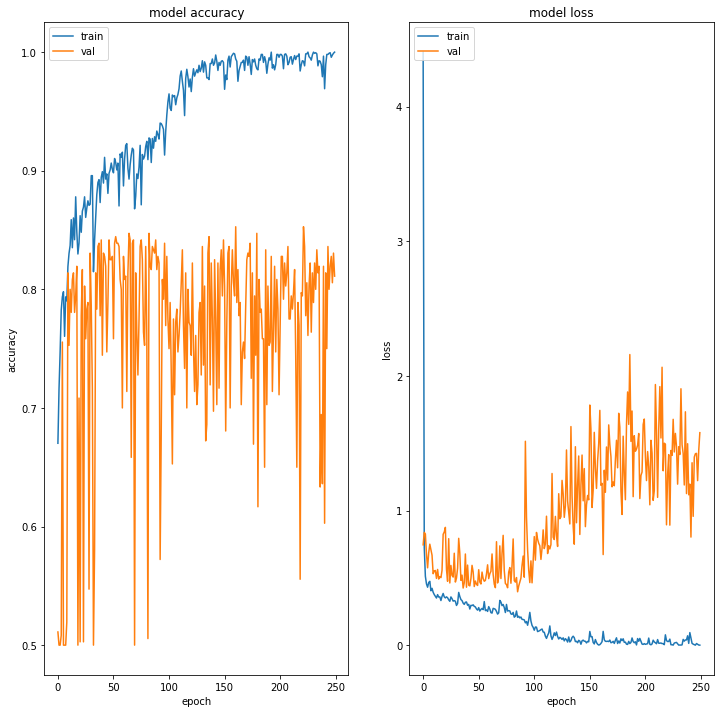

In [ ]:
# list all data in history
plt.figure(figsize=(12,12))
# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')


# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.show()

# **Grad CAM**


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Disciplina 10 - Visão Computacional 2/breakHis_dataset/SiDi_ViT_Final/SiDi_ViT')

In [ ]:
_, accuracy = model.evaluate(test)
print(f"Test accuracy: {round(accuracy * 100, 1)}%")

5/5 [==============================] - 14s 3s/step - loss: 0.4348 - accuracy: 0.9057
Test accuracy: 90.6%


In [ ]:
def get_img_array(img_path, size):

    # `img` is a PIL image of size 299x299
    img = tf.keras.utils.load_img(img_path, target_size=size)
    
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.utils.img_to_array(img)
    
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output,  model.output]
    )
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, predictions = grad_model(img_array)
        predictions = tf.squeeze(predictions)
        if pred_index is None:
            pred_index = tf.argmax(predictions)
        class_channel = predictions[pred_index]
        
        
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output#[0]
    #print(np.expand_dims(last_conv_layer_output,axis=0))
    #print(pooled_grads[..., tf.newaxis])
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
# Prepare image
def generate_heatmap(img_path):
    img_array = get_img_array(img_path, size=(224,224))
    img_array = img_array/255.0

    last_conv_layer_name = 'layer_normalization_20'

    # Print what the top predicted class is
    preds = model.predict(img_array)
    score = tf.nn.softmax(preds[0])
    proba = 100 * np.max(score)
    #top_pred_index = 100 * np.max(score)

    model_preds = tf.squeeze(tf.round(preds))
    top_pred_index = tf.argmax(score)
    #print("Pred 0", preds[0])
    #print("Score", score)

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    heatmap = np.reshape(heatmap, (14,14))
    heat_test = heatmap.copy()
    
    return heatmap, class_names[top_pred_index], proba

In [ ]:
def save_and_display_gradcam(img_path, heatmap, alpha=1, pred=None):

    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    if pred == 'malignant':
        jet = cm.get_cmap("jet")
    else:
        jet = cm.get_cmap("Greens")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
     
    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap) #keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = np.array(jet_heatmap) # keras.preprocessing.image.img_to_array(jet_heatmap)

    
    # only for generating images
    # Superimpose the heatmap on original image
    superimposed_img = (jet_heatmap * alpha) + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    
    # Otsu's thresholding
    jet_heatmap = cv.cvtColor(jet_heatmap, cv.COLOR_BGR2GRAY)

    _, thresh = cv.threshold(jet_heatmap,0,255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    plt.imshow(superimposed_img)
    return thresh

# Generating Dataset

In [ ]:
import json
import os 

In [ ]:
def loading_json(filen='/content/drive/MyDrive/Disciplina 10 - Visão Computacional 2/breakHis_dataset/groundTruth/'):
    tumor_cells = {}
    annot_points = {}
    
    for root, dirs, items in os.walk(filen):
        for i, item in enumerate(sorted(items)):
            #print(item)
            # Opening JSON file
            f = open(filen+item)
            # returns JSON object as 
            # a dictionary
            data = json.load(f)
            
            # adding values to dictionary
            tumor_cells[item.split('.')[0]] = len(data['tumor'])
            
            # creating list to get the annotations coordinates
            x_y = []
            for j, points in enumerate(data['tumor']):
                # list to get the coordinates of one annotation
                values_i_j = []
                
                # the values are multiplied by the image resolution
                values_i_j.append(int(points['x']*1360))
                values_i_j.append(int(points['y']*1024))
                
                # adding the coordinates to the list of one case
                x_y.append(values_i_j)
            
            # adding corresponding annotations to the respective case
            annot_points[item.split('.')[0]] = x_y

            # Closing file
            f.close()
            
    return tumor_cells, annot_points

In [ ]:
def getting_probs(filen='/content/drive/MyDrive/Disciplina 10 - Visão Computacional 2/breakHis_dataset/brecahad_TEST/brecahad_test_set/malignant/'): 
    
    # # loading test images
    probs = []
    classes = []
    masks = []
    for root, dirs, items in os.walk(filen):
        for item in sorted(items):
            #print(item)
            heatmap, class_, prob = generate_heatmap(filen+item)
            mask = save_and_display_gradcam(filen+item, heatmap, pred=class_)
            probs.append(round(prob,2))
            classes.append(class_)
            masks.append(mask)
            

    return classes, masks, probs

In [ ]:
def checking_points(annot_points, lst_heatmaps):
    
    # list to check the correct values
    correct_values = []
    i = 0
    
    for k, v in annot_points.items():
        got_it_right = 0
        mask_matrix = lst_heatmaps[i]
        
        for a, b in enumerate(v):
            if mask_matrix[b[1]][b[0]] > 0:
                got_it_right += 1
        # adding the correct correspondences to the list      
        correct_values.append(got_it_right)
        i += 1
        
    return correct_values

In [ ]:
def generating_dataset():
    
    tumor_cells, annot_points = loading_json()
    lst_classes, lst_heatmaps, lst_probs = getting_probs()
#     lst_tumors = interpretability(types=lst_classes, hmaps=lst_heatmaps)
    lst_tumors = checking_points(annot_points, lst_heatmaps)
    tumor_region = []
    accuracy = []
    
    # tumors found
    tumor_cells_values = list(tumor_cells.values())
    #print(str(tumor_cells.keys()).strip())
    for i, qtd in enumerate(lst_tumors):
        if lst_classes[i] == 'benign':
            tumor_region.append(0)
            accuracy.append(0)
            
        else:
            tumor_region.append(round((qtd/tumor_cells_values[i])*100, 2))
            
    
    dataframe = pd.DataFrame(data=[tumor_cells.keys(), tumor_cells.values(), lst_classes, lst_probs,
                                  lst_tumors, tumor_region],
                             index=['Case', 'Total Tumor Cells', 'Pred. Type', 'Probability (%)',
                                     'Tumors Found' ,'Interpret. Region Accuracy (%)']).transpose()
    
    return dataframe

## Dataset

In [ ]:
df = generating_dataset()

In [ ]:
df.head(15)

,Case,Total Tumor Cells,Pred. Type,Probability (%),Tumors Found,Interpret. Region Accuracy (%)
0,Case_1-01,140,malignant,99.82,10,7.14
1,Case_1-02,153,malignant,98.97,22,14.38
2,Case_1-03,135,malignant,98.85,74,54.81
3,Case_1-04,103,malignant,99.97,51,49.51
4,Case_1-05,126,malignant,99.44,16,12.7
5,Case_1-06,176,malignant,99.93,58,32.95
6,Case_1-07,196,malignant,99.93,26,13.27
7,Case_1-08,116,malignant,96.39,3,2.59
8,Case_10-01,162,malignant,99.98,99,61.11
9,Case_10-02,139,malignant,99.91,79,56.83


In [ ]:
df[df['Interpret. Region Accuracy (%)'] == df['Interpret. Region Accuracy (%)'].max()]

,Case,Total Tumor Cells,Pred. Type,Probability (%),Tumors Found,Interpret. Region Accuracy (%)
18,Case_11-09,27,malignant,88.39,27,100.0
136,Case_7-01,49,malignant,94.28,49,100.0


**Model Metrics**

In [ ]:
# Interpretability

mean = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].mean()
stdd = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].std()
summ_total = df[df['Pred. Type'] == 'malignant']['Total Tumor Cells'].sum()
summ_ind = df[df['Pred. Type'] == 'malignant']['Tumors Found'].sum()
median = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].median()
max_v = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].max()
min_v = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].min()
itp_model = round(mean, 2)
std_deviation = round(stdd, 2)
median_model = round(median, 2)

print(f'Model Average Interpretability: {itp_model} +/- {std_deviation}. With Median: {median_model}')
print(f'\nMin.: {min_v} | Max.: {max_v}')

Model Average Interpretability: 40.79 +/- 28.57. With Median: 38.06

Min.: 0.0 | Max.: 100.0


Text(0.5, 1.0, 'Histogram of Region Accuracy')

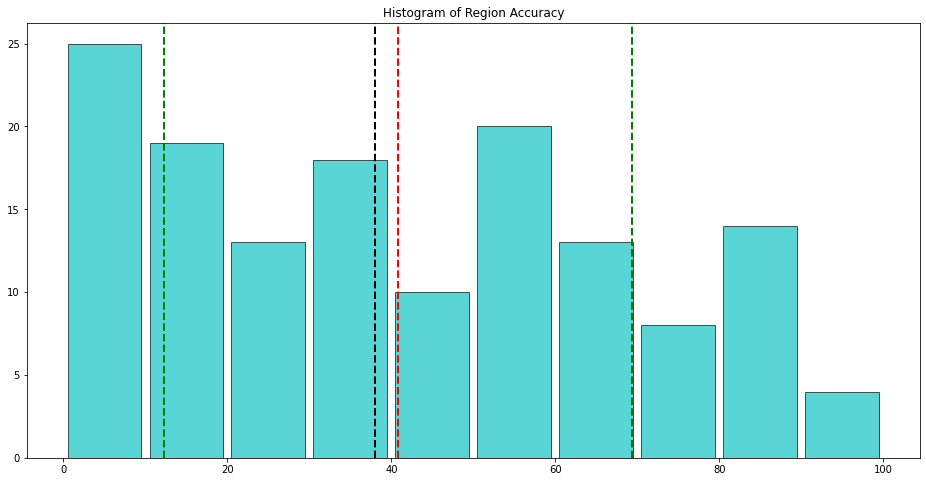

In [ ]:
plt.figure(figsize=(16,8))
values = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)']
plt.hist(x=values, bins=10, color='c', edgecolor='k', alpha=0.65, rwidth=0.9)
plt.axvline(values.median(), color='k', linestyle='dashed', linewidth=2)
plt.axvline(values.mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(values.mean() + values.std(), color='green', linestyle='dashed', linewidth=2)
plt.axvline(values.mean() - values.std(), color='green', linestyle='dashed', linewidth=2)
plt.title('Histogram of Region Accuracy')

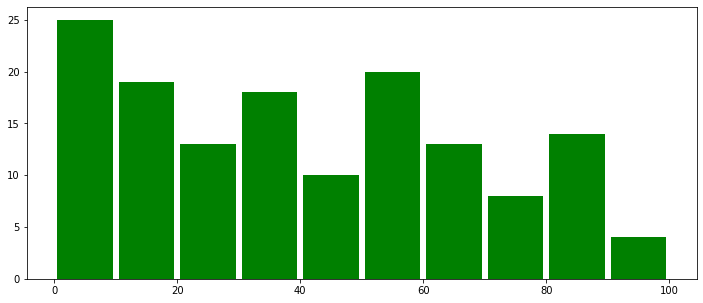

In [ ]:
plt.figure(figsize=(12,5))
values = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)']
plt.hist(x=values, bins=10, color='Green', rwidth=0.9);

In [ ]:
accuracy = 100*(len(df[(df['Pred. Type'] == 'malignant')].index)/len(df.index))
print("Acurácia de Classificação (%): ",round(accuracy,2))

Acurácia de Classificação (%):  90.57


## **Visualizando as imagens geradas**

### **Selecionando a imagem**

In [ ]:
case = 'Case_11-09.png'

In [ ]:
PATH1 = '/content/drive/MyDrive/Disciplina 10 - Visão Computacional 2/breakHis_dataset/groundTruth_display/'+case
IMG1 = '/content/drive/MyDrive/Disciplina 10 - Visão Computacional 2/breakHis_dataset/brecahad_TEST/brecahad_test_set/malignant/'+case

img = tf.keras.utils.load_img(PATH1)
img_orig = tf.keras.utils.load_img(IMG1)
heatmap1, class_1, probs1 = generate_heatmap(IMG1)

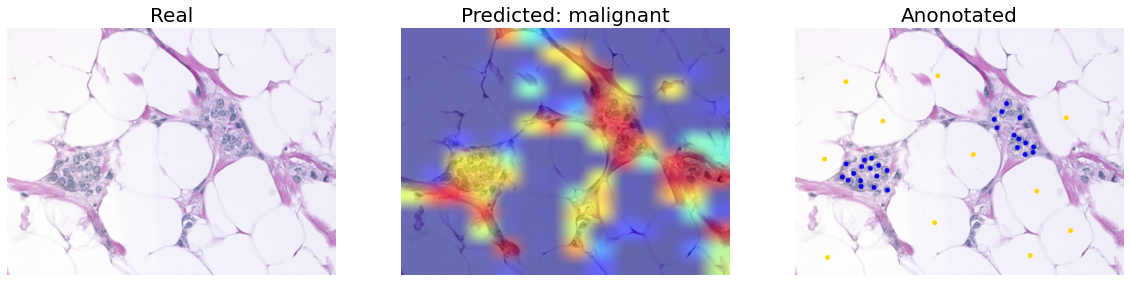

In [ ]:
plt.figure(figsize=(20,12))
plt.subplot(1,3,1)
plt.title('Real', fontsize=20)
plt.axis(False)
plt.imshow(img_orig)
plt.subplot(1,3,2)
plt.title(f'Predicted: {class_1}', fontsize=20)
plt.axis(False)
save_and_display_gradcam(img_path=IMG1, heatmap=heatmap1, pred=class_1)
plt.subplot(1,3,3)
plt.title('Anonotated', fontsize=20)
plt.axis(False)
plt.imshow(img)

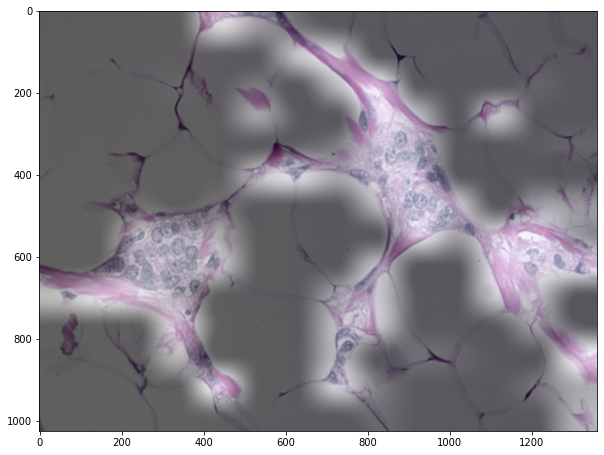

In [ ]:
plt.figure(figsize=(10,10))
result = save_and_display_gradcam(img_path=IMG1, heatmap=heatmap1, pred=class_1)

(1024, 1360)


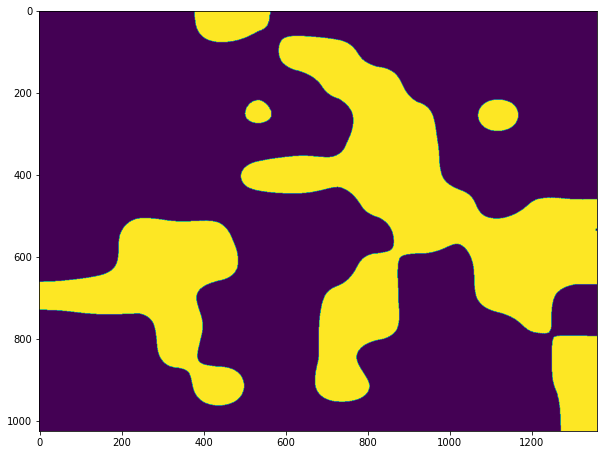

In [ ]:
plt.figure(figsize=(10,10))
print(result.shape)

plt.imshow(result)

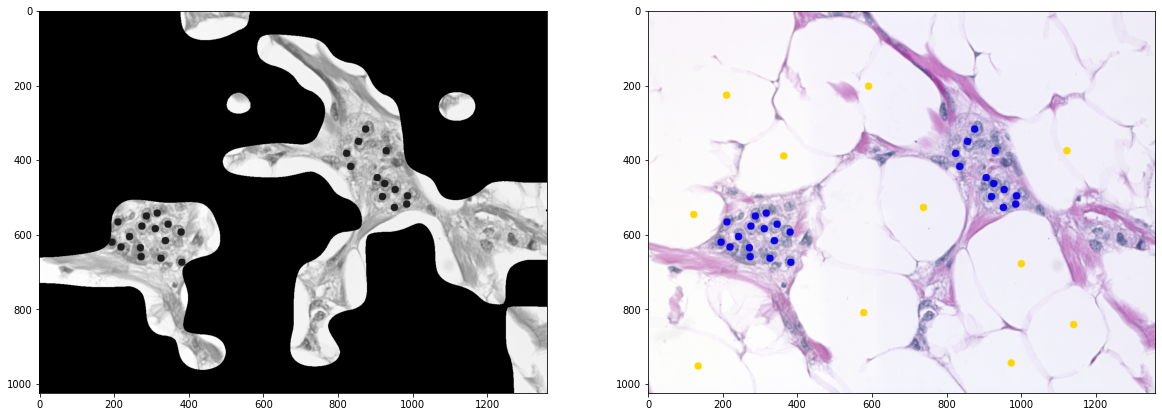

In [ ]:
# inverting result mask
plt.figure(figsize=(20,20))
data1 = cv.imread(PATH1)
data1 = cv.cvtColor(data1, cv.COLOR_BGR2RGB)
final = cv.bitwise_and(data1, data1, mask = result)
final = cv.cvtColor(final, cv.COLOR_RGB2GRAY)
plt.subplot(1,2,1)
plt.imshow(final, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(data1)

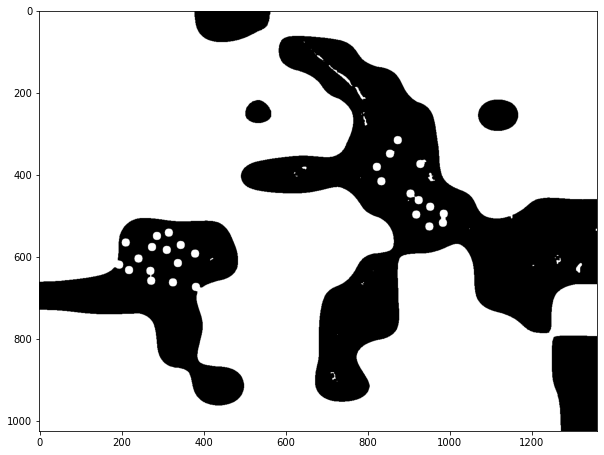

In [ ]:
plt.figure(figsize=(10,10))

kernel = np.ones((5,5),np.uint8)
mask2 = cv.threshold(final,0,255,cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
mask2 = cv.morphologyEx(mask2, cv.MORPH_CLOSE, kernel)
mask2 = np.uint8(mask2)
plt.imshow(mask2, cmap='gray')

(1, 26, 3)


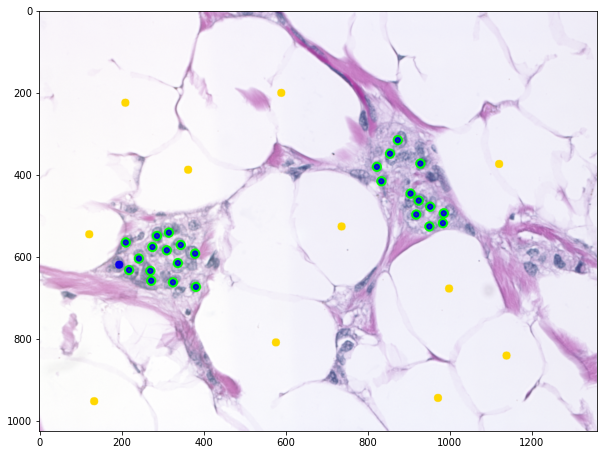

In [ ]:
plt.figure(figsize=(10,10))

data2 = data1.copy()

##########
p_edges = cv.Canny(mask2, 0, 255)

##########
rows = p_edges.shape[0]
circles = cv.HoughCircles(mask2, cv.HOUGH_GRADIENT, dp=1.1, minDist=1, param1=100, param2=15, minRadius=2, maxRadius=11)
print(circles.shape)

if circles is not None:
    # mudando o tipo de dado para int
    circles = np.uint16(np.around(circles))
    for circ in circles[0, :]:
        center = (circ[0], circ[1])

        # centro do círculo
        cv.circle(data2, center, 1, (0, 100, 100), 3)

        # círculo externo
        radius = circ[2]
        cv.circle(data2, center, radius, (0, 255, 0), 4)

plt.imshow(data2)